In [10]:
%matplotlib notebook
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

$$ \Delta w_{ij}(t) = \alpha \frac{w_{ij}(t)}{w_{max}} \left( f_{i} dt - x_i(t) \right)
                     + \gamma \left( \frac{w_{ij}(t)}{w_{max}} + 0.001 \right)
                     \sum_{\tau = 0}^{t} \left( x_i(t) K(\tau) x_{j}(t - \tau) - x_i(t - \tau) K(\tau) x_j(t) \right)
$$

If $$w_{ij}(t) > w_{max},$$ set $$w_{ij}(t) = w_{max}$$

$$ \sum_{j} w_{ij} > W_{max},$$

$$ w_{ij} = \frac{ w_{ij} }{ \sum_{j} w_{ij} } W_{max} $$

In [14]:
def graph_weight_matrix(mat, title, v_max=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)
    ax.clear()
    ax.matshow(mat, vmin=0, vmax=v_max if v_max is not None else mat.max(), cmap='hot')
    ax.set_title(title)
    set_font_size(ax, 14)

In [32]:
def animate(direc, frame_rate, v_max):
    file_names = sorted(all_files_from_dir(direc))
    plt.ion()
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)

    for i_f in range(0, len(file_names), frame_rate):
        file = file_names[i_f]
        loaded = sio.loadmat(os.path.join(direc, file))
        graph_weight_matrix(loaded['w_r_e'][:50, :50], '', ax=ax, v_max=v_max)
        fig.canvas.draw()
        time.sleep(0.000001)

        if i_f + frame_rate >= len(file_names):
            w_r_e = loaded['w_r_e']
            if 'w_r_i' in loaded:
                w_r_i = loaded['w_r_i']
    if w_r_i is not None:
        return w_r_e, w_r_i
    return w_r_e

<IPython.core.display.Javascript object>


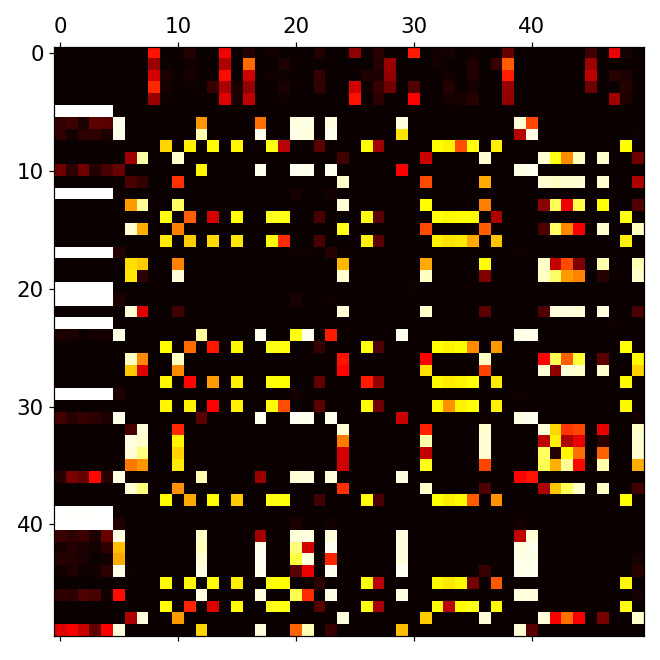

In [21]:
w_r = animate('./data/2020-12-07--17:08--53_0_0', 200, 0.26*0.004 / 5 * .81)

In [22]:
w_r[:50, :50]

array([[0.00000000e+00, 6.05585338e-08, 9.31625934e-08, ...,
        5.74354463e-05, 3.70704388e-06, 0.00000000e+00],
       [9.12746009e-08, 0.00000000e+00, 1.54121010e-07, ...,
        6.17865645e-11, 0.00000000e+00, 0.00000000e+00],
       [7.86514588e-08, 7.55912845e-08, 0.00000000e+00, ...,
        7.83249993e-06, 4.34419163e-06, 0.00000000e+00],
       ...,
       [4.01695717e-08, 4.04721157e-08, 4.19977074e-08, ...,
        0.00000000e+00, 1.27304164e-04, 1.57490213e-07],
       [1.18447096e-07, 1.18146564e-07, 1.21880724e-07, ...,
        0.00000000e+00, 0.00000000e+00, 1.59683069e-04],
       [5.35440327e-05, 5.90340436e-05, 4.74975101e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

<IPython.core.display.Javascript object>


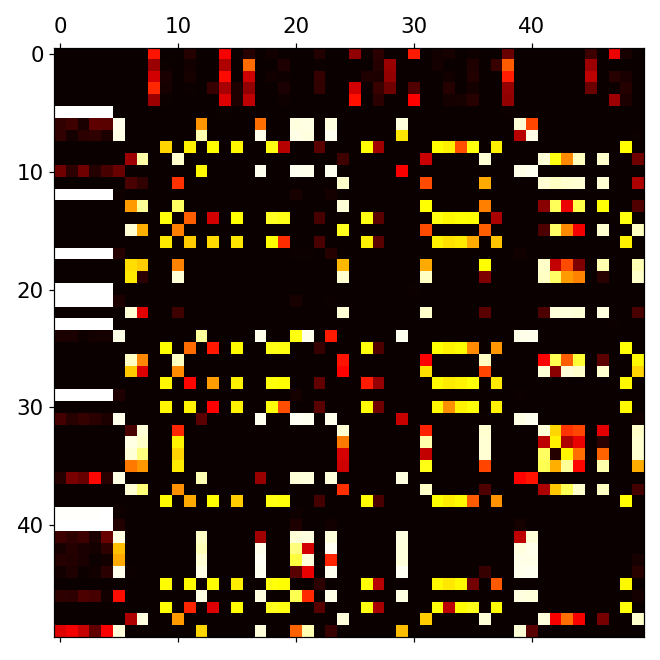

In [23]:
a = w_r[:50, :50]
graph_weight_matrix(a, title='', v_max=(0.26*0.004 / 5 * .81))

<IPython.core.display.Javascript object>


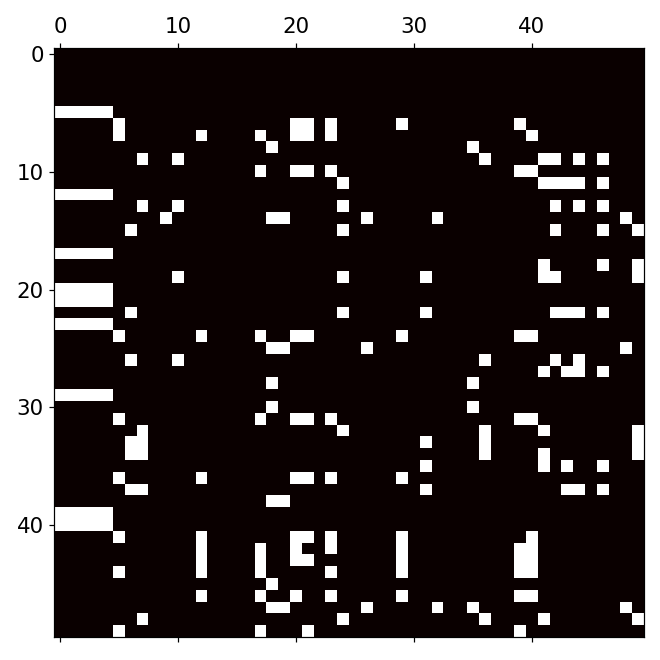

In [24]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee
a_prime = a > (0.26*0.004 / 5 * .81 * .75)
graph_weight_matrix(a_prime, title='')

In [25]:
b = csr_matrix(a_prime)
c = reverse_cuthill_mckee(b)

In [26]:
c

array([ 4,  3,  2,  1,  0,  7, 44, 36,  6, 24, 42, 10, 43, 31, 22, 37, 13,
       20, 40, 23, 29, 12, 11, 27, 39, 21, 17,  5, 34, 33, 15,  9, 32, 48,
       26, 19, 35, 46, 41, 49, 47, 14, 25, 38, 30, 28,  8, 18, 45, 16],
      dtype=int32)

In [27]:
a_prime[c,:]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

<IPython.core.display.Javascript object>


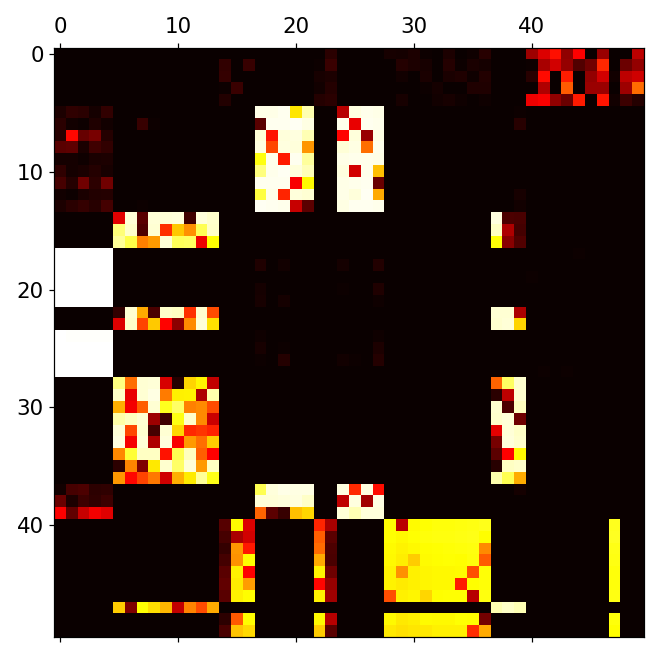

In [28]:
graph_weight_matrix(a[:, c][c, :], title='', v_max=(0.26*0.004 / 5 * .81))

<IPython.core.display.Javascript object>


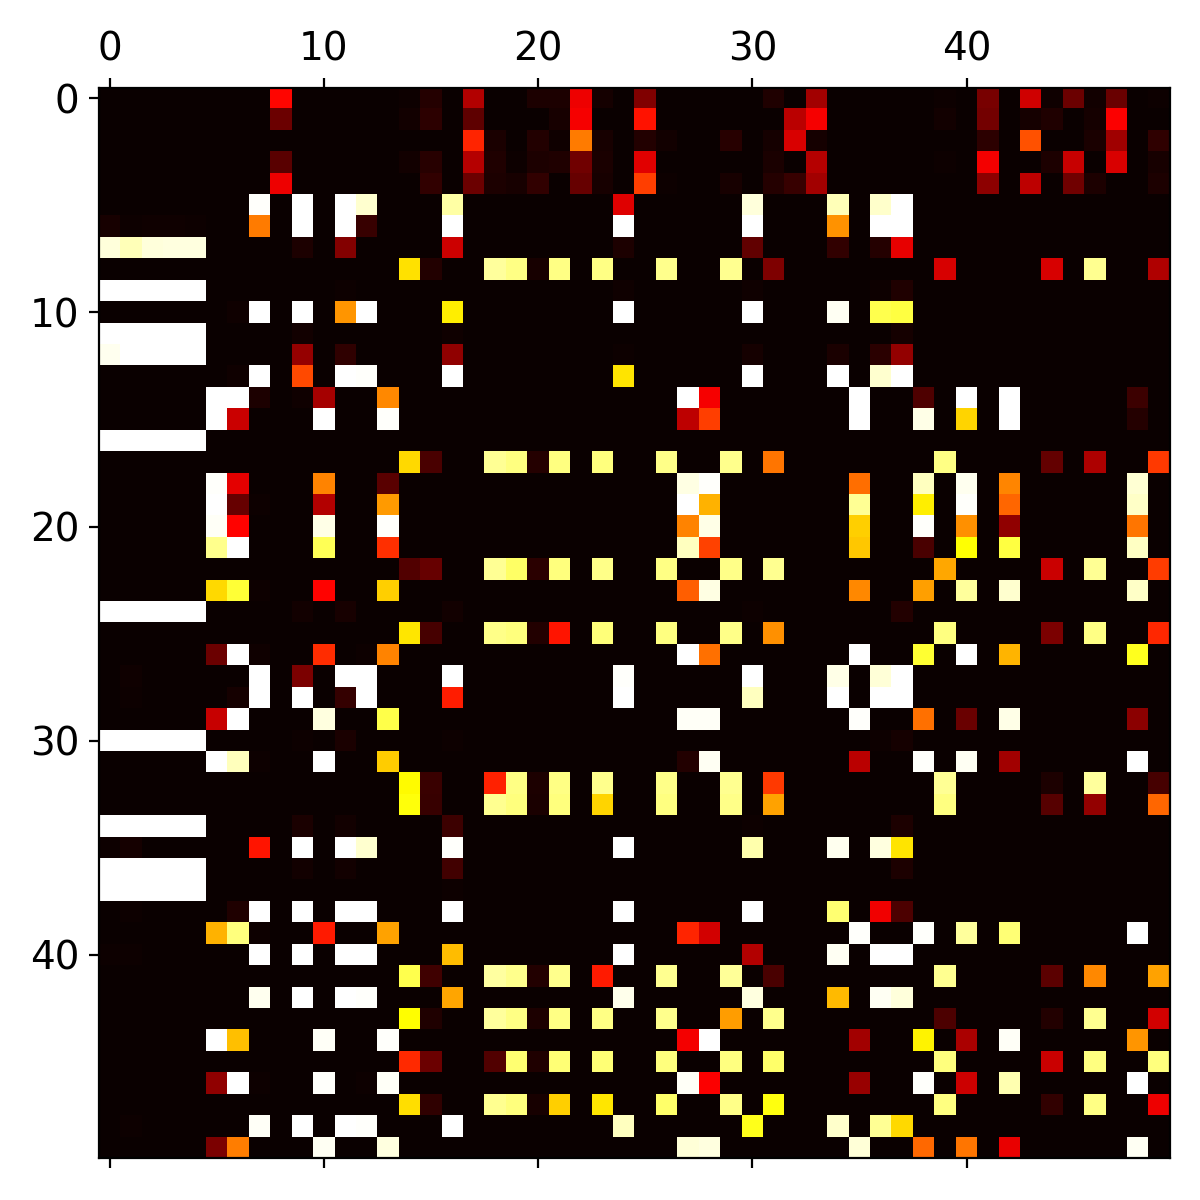

In [33]:
w_r_e, w_r_i = animate('./data/2020-12-15--00:11--08_0_0', 200, 0.26*0.004 / 5 * .81)

In [38]:
os.makedirs('./data/2020-12-15-00:11-15-0-0')

In [39]:
sio.savemat('./data/2020-12-15-00:11-15-0-0/001',
                    {'w_r_e': w_r_e, 'w_r_i': w_r_i})

In [40]:
w_r_e_2 = copy(w_r_e)

In [41]:
w_r_i_2 = copy(w_r_i)

<IPython.core.display.Javascript object>


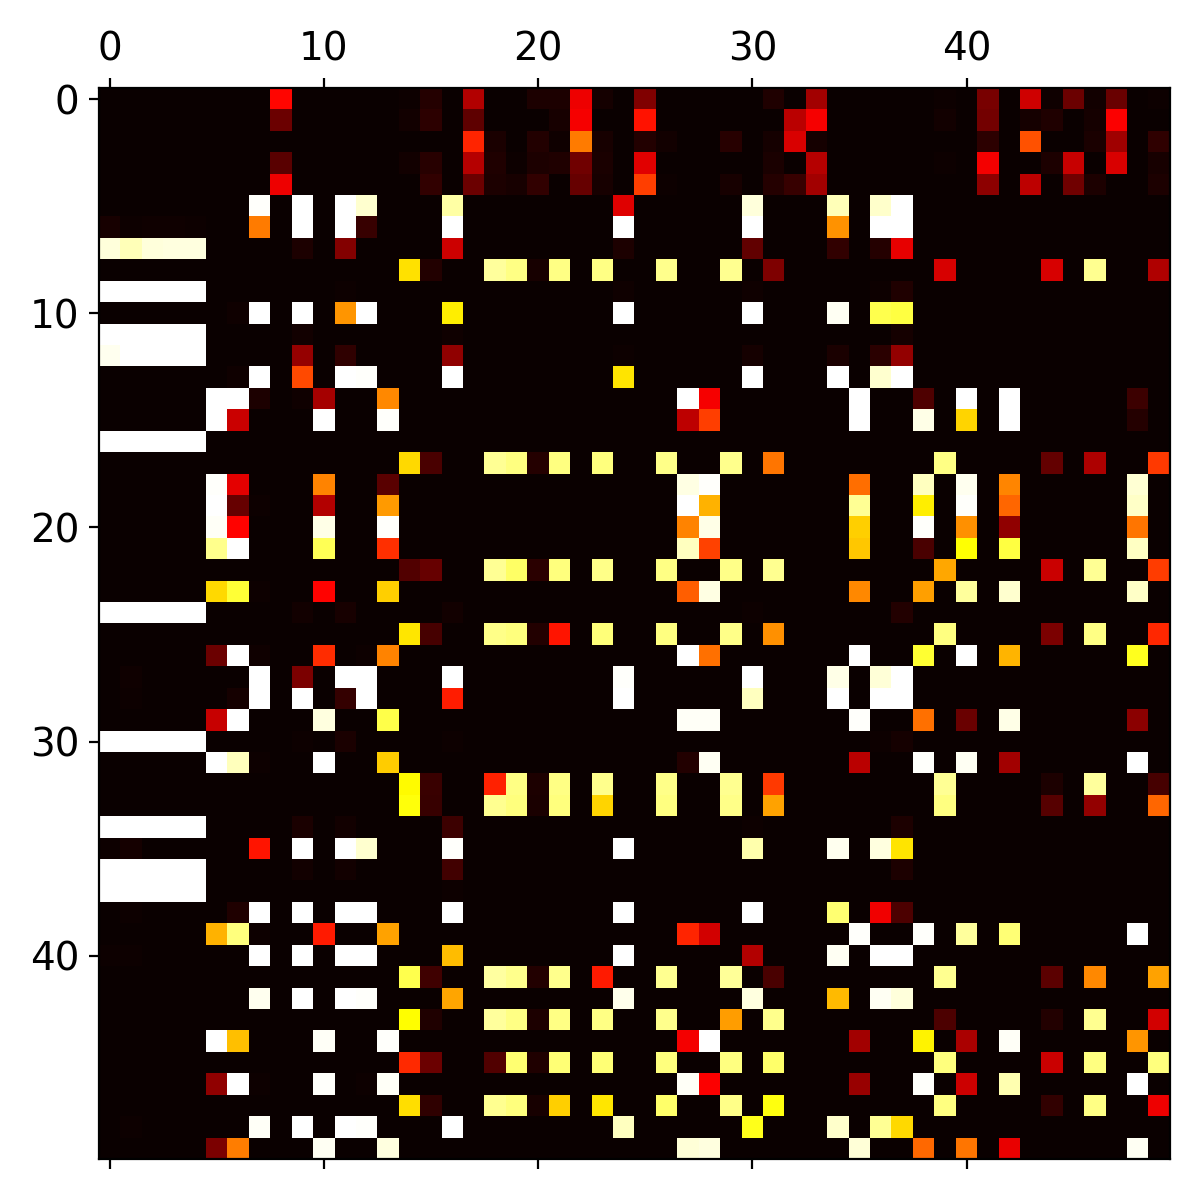

In [42]:
w_r_e, w_r_i = animate('./data/2020-12-15--00:11--15_0_0', 1, 0.26*0.004 / 5 * .81)